In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
import matplotlib.ticker as ticker


R = 1.1e6
errR = .1e6

data=np.loadtxt("fwhm_ch_50mm2_v2.txt")
V_bias = data[:,0]
V_buio = data[:,1]*1e-3 #in mV
ch = data[:,2]
err_ch = [1]*len(V_bias)
fwhm = data[:,4]
err_fwhm = data[:,5]*15

fwhm_ch= []
err_fwhm_ch = []

I_buio = []
err_vbias=[]
err_vbuio=[]
err_Ibuio=[]

for i in range(len(V_buio)):
    
    I_buio.append(V_buio[i]/R*1e6) #in uA
    err_vbias.append(0.5/100* V_bias[i])
    err_vbuio.append(0.5/100*V_buio[i])
    fwhm_ch.append(fwhm[i]/ch[i]*10**3)
    err_fwhm_ch.append(fwhm_ch[i]*np.sqrt((err_fwhm[i]/fwhm[i])**2+(err_ch[i]/ch[i])**2))

for i in range(len(V_buio)): 
    err_Ibuio.append(2.5*(err_vbuio[i]*1/R*1e6  + err_vbuio[i]*errR/R) ) #in uA


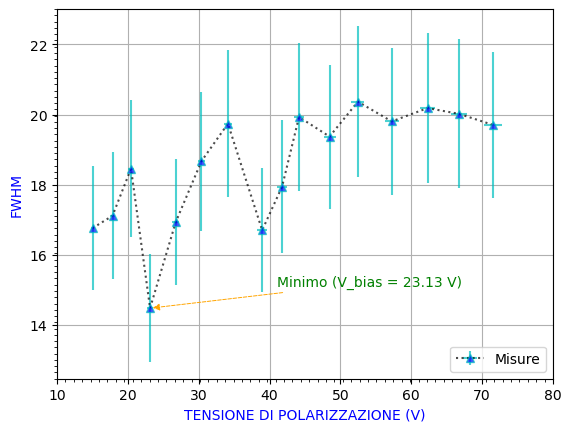

In [2]:

#Vbias Vs fwhm
fig, ax = plt.subplots()

plt.errorbar(V_bias, fwhm, xerr= list(map(lambda x: x*3.5, err_vbias)), yerr= err_fwhm, linestyle=":", marker="^", color="k", mec="c", mfc="b", ecolor="c", label="Misure", alpha=.7)
plt.grid("on")
plt.xlabel("TENSIONE DI POLARIZZAZIONE (V)", color="b")
plt.ylabel("FWHM", color="b")

plt.legend(loc = "lower right")
plt.style.use("ggplot")

plt.xlim(10, 80)
# For the x-axis
ax.xaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.xaxis.set_major_locator(ticker.LinearLocator(8))
# For the y-axis
ax.yaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.yaxis.set_major_locator(ticker.LinearLocator(8))

ax.annotate(f'Minimo (V_bias = {V_bias[3]} V)', xy=(V_bias[3], fwhm[3]),
             xycoords='data',
             xytext=(41, 15.1),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='orange',
                             lw=.7,
                             ls='--'),
            color="g"
           )

plt.show()

#togliamo dati

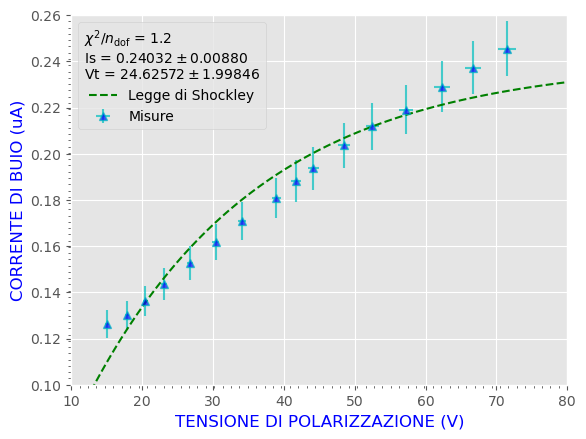

In [3]:
#FIT V bias VS I buio con f(x) = a $x^b$ + c $x^d$


func2=lambda x, Is, Vt: Is*(1-np.e**(-x/Vt))

#n=1

err=[]
for i in range(len(V_bias)):
    err.append(3.5*I_buio[i]*np.sqrt((err_Ibuio[i]/I_buio[i])**2+(err_vbias[i]/V_bias[i])**2))


least_squares = LeastSquares (V_bias, I_buio, err, func2)
my_minuit = Minuit (least_squares, Is=I_buio[-1], Vt=1) 
my_minuit.migrad ()  
my_minuit.hesse ()
#display(my_minuit)

x2 = np.linspace(10, 80, 100)

fig, ax = plt.subplots()

plt.errorbar(V_bias, I_buio, xerr=list(map(lambda x: x*3.5, err_vbias)), yerr=list(map(lambda x: x*3.5, err_Ibuio)), linestyle="None", marker = "^", color="k", mec="c", mfc="b", ecolor="c", label="Misure", alpha=.7)
plt.plot(x2, func2(x2, my_minuit.values[0], my_minuit.values[1] ), linestyle="--", color="g", label="Legge di Shockley")
plt.grid("on")
plt.xlabel("TENSIONE DI POLARIZZAZIONE (V)", color="b")
plt.ylabel("CORRENTE DI BUIO (uA)", color="b")

fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {my_minuit.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(my_minuit.parameters, my_minuit.values, my_minuit.errors):
    fit_info.append(f"{p} = ${v:.5f} \\pm {e:.5f}$")

plt.legend(title="\n".join(fit_info), frameon=True)

plt.style.use("ggplot")

plt.xlim(10, 80)
plt.ylim(0.1, 0.26)
# For the x-axis
ax.xaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.xaxis.set_major_locator(ticker.LinearLocator(8))
# For the y-axis
ax.yaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.yaxis.set_major_locator(ticker.LinearLocator(8))

plt.show()


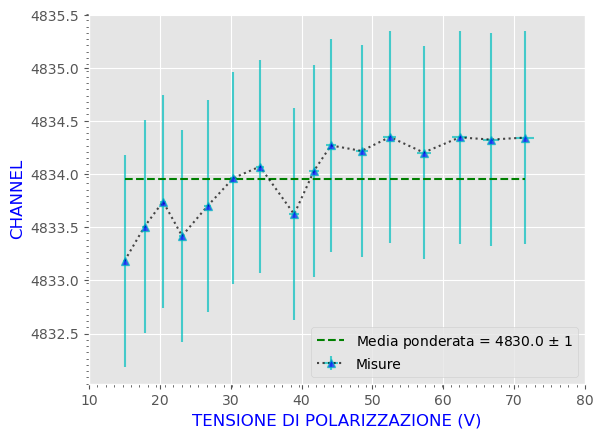

In [4]:
#Vbias vs channel
fig, ax = plt.subplots()

plt.errorbar(V_bias, ch, xerr=list(map(lambda x: x*3.5, err_vbias)), yerr=list(map(lambda x: x, err_ch)), linestyle=":", marker = "^", color="k", mec="c", mfc="b", ecolor="c", label="Misure", alpha=.7)
plt.grid("on")
plt.style.use("ggplot")
plt.xlabel("TENSIONE DI POLARIZZAZIONE (V)", color="b")
plt.ylabel("CHANNEL", color="b")


pesi = list(map(lambda x: 1/x**2, err_ch))
plateau = 0
for i in range(len(ch)):
    plateau = plateau + ch[i]*pesi[i]

plateau = plateau/sum(pesi)
err_plateau = 1/np.sqrt(sum(pesi))

plt.hlines(plateau, V_bias[0], V_bias[-1], linestyle="--", color="g", label=f"Media ponderata = {round(plateau,-1)} $\\pm$ {1}")

plt.xlim(10, 80)
#plt.ylim(round(ch[0], 1), round(ch[-1],1))
# For the x-axis
ax.xaxis.set_minor_locator(ticker.LinearLocator(60))
# For the y-axis
ax.yaxis.set_minor_locator(ticker.LinearLocator(60))

plt.legend(loc = "lower right")
plt.show()

#plt.savefig("ch vs V, 50mm2")

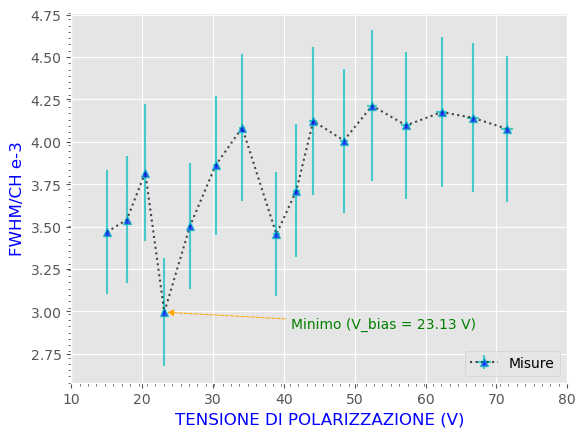

In [5]:
#V bias vs fhwm/ch
fig, ax = plt.subplots()

plt.errorbar(V_bias, fwhm_ch, xerr= list(map(lambda x: x*2.5, err_vbias)), yerr= list(map(lambda x: x, err_fwhm_ch)), linestyle=":", marker="^", label="Misure", color="k", mec="c", mfc="b", ecolor="c", alpha=.7)


plt.grid("on")
plt.xlabel("TENSIONE DI POLARIZZAZIONE (V)", color="b")
plt.ylabel(f"FWHM/CH e-3", color="b")

plt.style.use("ggplot")
plt.legend(loc = "lower right")

plt.xlim(10, 80)
#plt.ylim(round(ch[0], 1), round(ch[-1],1))
# For the x-axis
ax.xaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.xaxis.set_major_locator(ticker.LinearLocator(8))
# For the y-axis
ax.yaxis.set_minor_locator(ticker.LinearLocator(60))
#ax.yaxis.set_major_locator(ticker.LinearLocator(8))

ax.annotate(f'Minimo (V_bias = {V_bias[3]} V)', xy=(V_bias[3], fwhm_ch[3]),
             xycoords='data',
             xytext=(41, 2.9),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='orange',
                             lw=.7,
                             ls='--'),
            color="g"
           )
plt.show()
#plt.savefig("fwhmch vs V, 50mm2")

In [6]:
print(fwhm_ch[3], err_fwhm_ch[3]) 
print(V_bias[3], err_vbias[3])

2.995332559457539 0.31716733865624247
23.13 0.11565
